In [1]:

%pprint
import sys
if (osp.join('..', 'py') not in sys.path): sys.path.insert(1, osp.join('..', 'py'))

Pretty printing has been turned OFF


In [2]:

from FRVRS import (nu, fu, DataFrame, Index, Series, concat, math, np, osp, re, sm, isna)
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


# Refactor Ideal Engagement Order

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='',
    first_responder_master_registry_scene_stats_df='',
    category_history_df='', Correct_order_of_FIRST11=''
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
elevens_df = fu.get_elevens_dataframe(
    triage_paper_df, file_stats_df, scene_stats_df,
    needed_columns=['scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'session_file_date']
)
Correct_order_of_FIRST11_df = data_frames_dict['Correct_order_of_FIRST11']
engagement_dict = {patient_str + ' Root': group_id for (patient_str, group_id), patient_group_df in Correct_order_of_FIRST11_df.groupby(
    ['Patient', 'Group']
)}
first11_patients_list = [p + ' Root' for p in Correct_order_of_FIRST11_df.Patient]
first11_df = elevens_df.groupby(fu.scene_groupby_columns).filter(
    lambda scene_df: scene_df[~scene_df.patient_id.isnull()].patient_id.isin(first11_patients_list).all()
)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_file_stats_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_scene_stats_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/category_history_df.pkl.
No csv exists for Correct_order_of_FIRST11 - trying /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/data/csv/Correct_order_of_FIRST11.csv.


In [4]:

# Test all the methods used in this notebook in one test suite
import unittest
if ('../tests' not in sys.path): sys.path.insert(1, '../tests')
suite = unittest.TestSuite()

# Add all test cases from each class to the suite
from test_notebook_utils_ordering_functions import (
    TestCountSwapsToPerfectOrder
)
suite.addTest(unittest.makeSuite(TestCountSwapsToPerfectOrder))

# Run the test suite
runner = unittest.TextTestRunner()
runner.run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.004s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [5]:

engagement_dict

{'Bob_0 Root': 1, 'Bob_9 Root': 3, 'Gary_1 Root': 1, 'Gary_3 Root': 1, 'Gloria_6 Root': 2, 'Gloria_8 Root': 3, 'Helga_10 Root': 3, 'Lily_2 Root': 1, 'Lily_4 Root': 1, 'Mike_5 Root': 1, 'Mike_7 Root': 1}

In [6]:

from scipy.stats import kendalltau

rows_list = []
for (session_uuid, scene_id), scene_df in first11_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    
    actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_patient_sort_sequences(scene_df)
    if isna(actual_sequence).all(): continue
    row_dict = nu.get_flattened_dictionary(actual_sequence.tolist(), row_dict=row_dict, key_prefix='actual_sequence')
    row_dict = nu.get_flattened_dictionary(ideal_sequence.tolist(), row_dict=row_dict, key_prefix='ideal_sequence')
    
    engagement_order = fu.get_order_of_actual_engagement(scene_df)
    engagement_order_dicts_list = [
        {
            'patient_id': engagement_tuple[0],
            'engagement_start': engagement_tuple[1],
            'location_tuple': engagement_tuple[2],
            'patient_sort': engagement_tuple[3],
            'predicted_priority': engagement_tuple[4],
            'injury_severity': engagement_tuple[5]
        } for engagement_tuple in engagement_order
    ]
    row_dict = nu.get_flattened_dictionary(engagement_order_dicts_list, row_dict=row_dict, key_prefix='engagement_order')
    
    actual_patient_sequence = Series([engagement_dict.get(engagement_tuple[0]) for engagement_tuple in engagement_order])
    row_dict = nu.get_flattened_dictionary(actual_patient_sequence.tolist(), row_dict=row_dict, key_prefix='actual_patient_sequence')
    
    ideal_patient_sequence = actual_patient_sequence.sort_values(ascending=True)
    row_dict = nu.get_flattened_dictionary(ideal_patient_sequence.tolist(), row_dict=row_dict, key_prefix='ideal_patient_sequence')
    
    measure_of_ordering = fu.get_measure_of_ordering(actual_patient_sequence, ideal_patient_sequence)
    row_dict['measure_of_ordering'] = measure_of_ordering

    swaps_to_perfect_order = nu.count_swaps_to_perfect_order(ideal_patient_sequence.tolist(), actual_patient_sequence.tolist())
    row_dict['swaps_to_perfect_order'] = swaps_to_perfect_order
    
    # Calculate Kendall's tau coefficient
    tau, p_value = kendalltau(ideal_patient_sequence.tolist(), actual_patient_sequence.tolist())
    row_dict['kendall_tau_coefficient'] = tau
    
    rows_list.append(row_dict)
measure_of_ordering_df = DataFrame(rows_list)

In [7]:

measure_of_ordering_df.sort_values('kendall_tau_coefficient').head(5).dropna(axis='columns', how='all').T

,28,17,11,37,29
session_uuid,991af001-9414-4a2d-8079-0663c4ddb1e4,38b995b3-fb77-4fda-b0b4-21f062ed6a38,26f08763-076e-4531-a6f7-f00232f664bd,b1ebfdc9-6338-4b80-ba76-947f8690bd91,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13
scene_id,0,0,0,0,1
actual_sequence00,54837.0,65654.0,30996.0,48140.0,261333.0
actual_sequence01,56460.0,69168.0,39071.0,87445.0,262646.0
actual_sequence02,78736.0,126165.0,84011.0,165001.0,276234.0
...,...,...,...,...,...
ideal_patient_sequence4,NaN,NaN,1.0,NaN,NaN
ideal_patient_sequence5,NaN,NaN,1.0,NaN,NaN
ideal_patient_sequence6,NaN,NaN,1.0,NaN,NaN
ideal_patient_sequence7,NaN,NaN,2.0,NaN,NaN


In [9]:

measure_of_ordering_df.shape

(48, 187)

In [15]:

measure_of_ordering_df.swaps_to_perfect_order.value_counts(normalize=True, sort=True).sort_index()

0    0.062500
1    0.333333
2    0.104167
3    0.062500
4    0.229167
5    0.041667
6    0.166667
Name: swaps_to_perfect_order, dtype: float64

In [16]:

measure_of_ordering_df.measure_of_ordering.value_counts(normalize=True, sort=True).sort_index()

-0.142857    0.020833
-0.118343    0.020833
-0.107967    0.062500
-0.106584    0.041667
-0.074770    0.041667
-0.071429    0.020833
-0.019441    0.062500
 0.041420    0.041667
 0.080152    0.041667
 0.080152    0.166667
 0.203259    0.062500
 0.203259    0.020833
 0.356798    0.020833
 0.739369    0.041667
 0.755168    0.270833
 1.000000    0.062500
Name: measure_of_ordering, dtype: float64

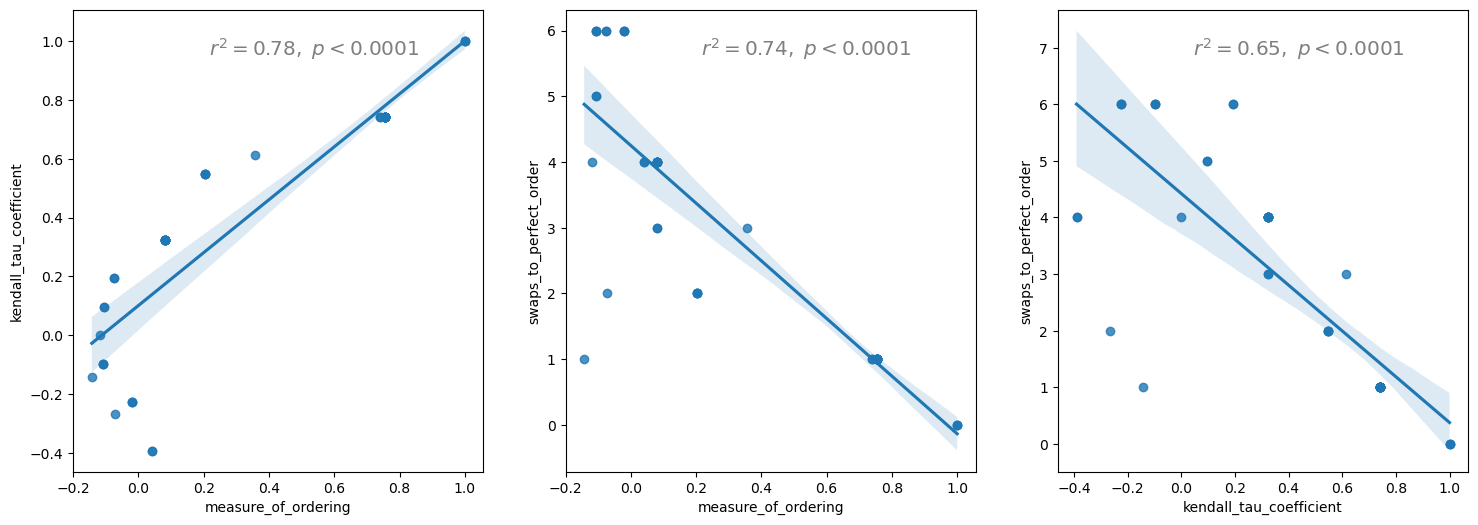

In [18]:

from itertools import combinations
import seaborn as sns

columns_list = ['measure_of_ordering', 'kendall_tau_coefficient', 'swaps_to_perfect_order']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i, list_pair in enumerate(combinations(columns_list, 2)):
    _ = sns.regplot(x=list_pair[0], y=list_pair[1], scatter=True, data=measure_of_ordering_df, ax=axes[i])
    
    # Annotate r squared value
    s_str = nu.get_r_squared_value_latex(measure_of_ordering_df[list_pair[0]], measure_of_ordering_df[list_pair[1]])
    text_tuple = axes[i].text(0.33, 0.9, s_str, alpha=0.5, transform=axes[i].transAxes, fontsize='x-large')

In [23]:

from IPython.display import HTML

for cn in columns_list:
    print()
    print(cn)
    for row_index, row_series in nu.get_statistics(measure_of_ordering_df, [cn]).iterrows():
        print(row_index, row_series.squeeze())


measure_of_ordering
mean 0.3181783083494876
mode 0.7551682510940094
median 0.08015190382777548
SD 0.38914315408262845
min -0.1428571428571428
25% -0.019440671998390613
50% 0.08015190382777548
75% 0.7551682510940094
max 1.0

kendall_tau_coefficient
mean 0.38707649076980544
mode 0.7419354838709679
median 0.32258064516129037
SD 0.39554285494375246
min -0.39130434782608703
25% 0.09677419354838711
50% 0.32258064516129037
75% 0.7419354838709679
max 1.0

swaps_to_perfect_order
mean 2.8541666666666665
mode 1.0
median 2.5
SD 1.9892218443650997
min 0.0
25% 1.0
50% 2.5
75% 4.0
max 6.0


In [5]:

distracted_sequence = Series([engagement_dict.get(engagement_tuple[0]) for engagement_tuple in fu.get_order_of_distracted_engagement(scene_df)])
fu.get_measure_of_ordering(actual_sequence, distracted_sequence)

-0.019440671998390613

In [7]:

input_features = [
    'injury_id', 'injury_severity', 'injury_required_procedure', 'patient_salt', 'patient_sort', 'patient_pulse', 'patient_breath',
    'patient_hearing', 'patient_mood', 'patient_pose'
    ]

In [39]:

ml_columns = ['lr_triage_priority_model_prediction', 'dtr_triage_priority_model_prediction']
stats_column_name = 'stats_type'
stats_columns_list = fu.scene_groupby_columns + ['patient_id', stats_column_name] + ml_columns
scene_stats_df = DataFrame([], columns=stats_columns_list)
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):

    # Create the patient sort tuples list
    engagement_starts_list = []
    patient_stats_df = DataFrame([], columns=stats_columns_list)
    for patient_id, patient_df in scene_df.groupby('patient_id'):

        # Get the cluster ID, if available
        mask_series = ~patient_df.patient_sort.isnull()
        patient_sort = (
            patient_df[mask_series].sort_values('action_tick').iloc[-1].patient_sort
            if mask_series.any():
            else None
        )

        # Check if the responder even interacted with this patient
        mask_series = patient_df.action_type.isin(fu.responder_negotiations_list)
        if mask_series.any():

            # Get the list of engagements as action ticks
            engagements_list = patient_df[mask_series].action_tick
            mask_series = patient_df.action_tick.isin(engagements_list) & ~patient_df.location_id.isnull()
            if mask_series.any():
                df = patient_df[mask_series].sort_values('action_tick')

                # Get the first engagement start and location
                engagement_start = df.iloc[0].action_tick
                engagement_location = eval(df.iloc[0].location_id) # Evaluate string to get tuple
                location_tuple = (engagement_location[0], engagement_location[2])

                # Add engagement information to the list
                engagement_tuple = (patient_id, engagement_start, location_tuple, patient_sort)
                engagement_starts_list.append(engagement_tuple)
                
                # Get the patient stats
                df = nu.get_statistics(patient_df, ml_columns).reset_index(drop=False).rename(columns={'index': stats_column_name})
                for cn in fu.scene_groupby_columns: df[cn] = eval(cn)
                df['patient_id'] = patient_id
                df = df[stats_columns_list]
                
                # Append the data frame for the current patient to the stats data frame
                patient_stats_df = concat([patient_stats_df, df], axis='index').reset_index(drop=True)

    # Sort the starts list chronologically
    actual_engagement_order = sorted(engagement_starts_list, key=lambda x: x[1], reverse=False)
    engagement_starts_dict = {patient_id: engagement_start for patient_id, engagement_start, location_tuple, patient_sort in actual_engagement_order}
    
    # Calculate the R-squared adjusted value as a measure of derived ordering
    y = Series([t[1] for t in actual_engagement_order]).values.reshape(-1, 1)
    max_measure = -2
    max_stats_type = 'stats_type'
    max_ml_column = 'ml_column'
    max_ascending = 'ascending'
    for stats_type in patient_stats_df.stats_type.unique():
        mask_series = (patient_stats_df.stats_type == stats_type)
        for ml_column in ml_columns:
            for ascending in [True, False]:
                derived_engagement_order = patient_stats_df[mask_series].sort_values(ml_column, ascending=ascending).patient_id.tolist()
                X = Series([engagement_starts_dict[patient_id] for patient_id in derived_engagement_order]).values.reshape(-1, 1)
                if X.shape[0]:
                    X1 = sm.add_constant(X)
                    try:
                        measure_of_derived_ordering = sm.OLS(y, X1).fit().rsquared_adj
                        if (max_measure < measure_of_derived_ordering):
                            max_measure = measure_of_derived_ordering
                            max_stats_type = stats_type
                            max_ml_column = ml_column
                            max_ascending = ascending
                    except: continue
    patient_stats_df['max_measure'] = max_measure
    patient_stats_df['max_stats_type'] = max_stats_type
    patient_stats_df['max_ml_column'] = max_ml_column
    patient_stats_df['max_ascending'] = max_ascending
    
    # Append the data frame for the current patient to the stats data frame
    scene_stats_df = concat([scene_stats_df, patient_stats_df], axis='index').reset_index(drop=True)

In [51]:

mask_series = (scene_stats_df.max_measure == 1.0)
display(scene_stats_df[mask_series].max_stats_type.value_counts())

mean    837
25%     432
SD      378
max     261
mode    171
min      45
75%      36
Name: max_stats_type, dtype: int64

In [57]:

mask_series = (scene_stats_df.max_measure == 1.0) & (scene_stats_df.max_stats_type == 'mean')
display(scene_stats_df[mask_series].max_ml_column.value_counts())

dtr_triage_priority_model_prediction    630
lr_triage_priority_model_prediction     207
Name: max_ml_column, dtype: int64

In [58]:

mask_series = (scene_stats_df.max_measure == 1.0) & (scene_stats_df.max_stats_type == 'mean')
mask_series &= (scene_stats_df.max_ml_column == 'dtr_triage_priority_model_prediction')
display(scene_stats_df[mask_series].max_ascending.value_counts())

True     522
False    108
Name: max_ascending, dtype: int64

In [61]:

mask_series = (scene_stats_df.max_measure == 1.0) & (scene_stats_df.max_stats_type == 'mean')
mask_series &= (scene_stats_df.max_ml_column == 'dtr_triage_priority_model_prediction')
mask_series &= scene_stats_df.max_ascending
columns_list = [
    'patient_id', 'stats_type', 'lr_triage_priority_model_prediction', 'dtr_triage_priority_model_prediction'
]
display(scene_stats_df[mask_series][columns_list])

,patient_id,stats_type,lr_triage_priority_model_prediction,dtr_triage_priority_model_prediction
5868,Mike_0 Root,mean,7.081984,7.375000
5869,Mike_0 Root,mode,8.623898,9.000000
5870,Mike_0 Root,median,8.623898,9.000000
5871,Mike_0 Root,SD,2.075794,2.939736
5872,Mike_0 Root,min,3.926232,2.500000
...,...,...,...,...
41692,Mike_3 Root,min,5.734049,8.000000
41693,Mike_3 Root,25%,6.206855,8.000000
41694,Mike_3 Root,50%,8.623898,9.000000
41695,Mike_3 Root,75%,8.623898,9.000000


In [ ]:

mask_series = (patient_stats_df.stats_type == 'mean')
derived_engagement_order = patient_stats_df[mask_series].sort_values('dtr_triage_priority_model_prediction', ascending=True).patient_id.tolist()

In [39]:

for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):

    # Create the patient sort tuples list
    engagement_starts_list = []
    patient_stats_df = DataFrame([], columns=stats_columns_list)
    for patient_id, patient_df in scene_df.groupby('patient_id'):

        # Get the cluster ID, if available
        mask_series = ~patient_df.patient_sort.isnull()
        patient_sort = (
            patient_df[mask_series].sort_values('action_tick').iloc[-1].patient_sort
            if mask_series.any():
            else None
        )

        # Check if the responder even interacted with this patient
        mask_series = patient_df.action_type.isin(fu.responder_negotiations_list)
        if mask_series.any():

            # Get the list of engagements as action ticks
            engagements_list = patient_df[mask_series].action_tick
            mask_series = patient_df.action_tick.isin(engagements_list) & ~patient_df.location_id.isnull()
            if mask_series.any():
                df = patient_df[mask_series].sort_values('action_tick')

                # Get the first engagement start and location
                engagement_start = df.iloc[0].action_tick
                engagement_location = eval(df.iloc[0].location_id) # Evaluate string to get tuple
                location_tuple = (engagement_location[0], engagement_location[2])

                # Add engagement information to the list
                engagement_tuple = (patient_id, engagement_start, location_tuple, patient_sort)
                engagement_starts_list.append(engagement_tuple)
                
                # Get the patient stats
                df = nu.get_statistics(patient_df, ml_columns).reset_index(drop=False).rename(columns={'index': stats_column_name})
                for cn in fu.scene_groupby_columns: df[cn] = eval(cn)
                df['patient_id'] = patient_id
                df = df[stats_columns_list]
                
                # Append the data frame for the current patient to the stats data frame
                patient_stats_df = concat([patient_stats_df, df], axis='index').reset_index(drop=True)

    # Sort the starts list chronologically
    actual_engagement_order = sorted(engagement_starts_list, key=lambda x: x[1], reverse=False)
    engagement_starts_dict = {patient_id: engagement_start for patient_id, engagement_start, location_tuple, patient_sort in actual_engagement_order}
    
    # Calculate the R-squared adjusted value as a measure of derived ordering
    y = Series([t[1] for t in actual_engagement_order]).values.reshape(-1, 1)
    max_measure = -2
    max_stats_type = 'stats_type'
    max_ml_column = 'ml_column'
    max_ascending = 'ascending'
    for stats_type in patient_stats_df.stats_type.unique():
        mask_series = (patient_stats_df.stats_type == stats_type)
        for ml_column in ml_columns:
            for ascending in [True, False]:
                derived_engagement_order = patient_stats_df[mask_series].sort_values(ml_column, ascending=ascending).patient_id.tolist()
                X = Series([engagement_starts_dict[patient_id] for patient_id in derived_engagement_order]).values.reshape(-1, 1)
                if X.shape[0]:
                    X1 = sm.add_constant(X)
                    try:
                        measure_of_derived_ordering = sm.OLS(y, X1).fit().rsquared_adj
                        if (max_measure < measure_of_derived_ordering):
                            max_measure = measure_of_derived_ordering
                            max_stats_type = stats_type
                            max_ml_column = ml_column
                            max_ascending = ascending
                    except: continue
    patient_stats_df['max_measure'] = max_measure
    patient_stats_df['max_stats_type'] = max_stats_type
    patient_stats_df['max_ml_column'] = max_ml_column
    patient_stats_df['max_ascending'] = max_ascending
    
    # Append the data frame for the current patient to the stats data frame
    scene_stats_df = concat([scene_stats_df, patient_stats_df], axis='index').reset_index(drop=True)